# Classical Multivariate: Vector Autoregression (VAR)

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

def check_stationarity(data):
    """Perform ADF test on each column to check for stationarity."""
    for col in data.columns:
        result = adfuller(data[col])
        # If p-value > 0.05, the series is likely non-stationary [cite: 154]
        print(f"ADF Statistic for {col}: {result[0]:.4f} (p-value: {result[1]:.4f})")

# Sample data: Advertising spend and Sales [cite: 133]
df_var = pd.DataFrame({
    "advertising": [10, 11, 12, 15, 14, 16, 18, 20, 19, 21],
    "sales": [100, 105, 110, 130, 125, 140, 155, 170, 165, 180]
}, index=pd.date_range("2025-01-01", periods=10, freq="D"))

# Step 1: Statistical Tests
check_stationarity(df_var)

# Test if advertising Granger-causes sales [cite: 190]
grangercausalitytests(df_var[["sales", "advertising"]], maxlag=2)

# Step 2: Fit VAR model with automatic lag selection via AIC [cite: 160]
model_var = VAR(df_var)
results_var = model_var.fit(maxlags=2, ic="aic")

# Step 3: Forecast 3 steps ahead [cite: 166]
lag_order = results_var.k_ar
forecast_values = results_var.forecast(y=df_var.values[-lag_order:], steps=3)

ADF Statistic for advertising: 0.4434 (p-value: 0.9830)
ADF Statistic for sales: 0.8023 (p-value: 0.9917)

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0699  , p=0.8003  , df_denom=6, df_num=1
ssr based chi2 test:   chi2=0.1049  , p=0.7460  , df=1
likelihood ratio test: chi2=0.1043  , p=0.7467  , df=1
parameter F test:         F=0.0699  , p=0.8003  , df_denom=6, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1435  , p=0.8720  , df_denom=3, df_num=2
ssr based chi2 test:   chi2=0.7652  , p=0.6821  , df=2
likelihood ratio test: chi2=0.7307  , p=0.6939  , df=2
parameter F test:         F=0.1435  , p=0.8720  , df_denom=3, df_num=2


# Global Modeling with mlforecast

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] Start training from score 126.823517
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

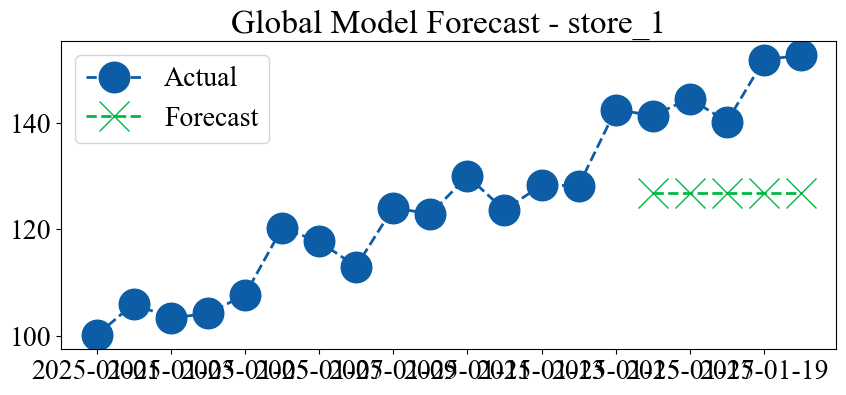

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mlforecast import MLForecast
from lightgbm import LGBMRegressor
from utilsforecast.losses import mae

def generate_extended_data():
    """Create a larger dataset to enable model training and evaluation."""
    dates = pd.date_range("2025-01-01", periods=20, freq="D")
    data = []
    for store in ["store_1", "store_2"]:
        # Create a simple trend with noise
        values = np.linspace(100, 150, 20) + np.random.normal(0, 5, 20)
        for d, y in zip(dates, values):
            data.append({
                "unique_id": store,
                "ds": d,
                "y": y,
                "is_promotion": np.random.choice([0, 1])
            })
    return pd.DataFrame(data)

# Step 1: Data Preparation
df_extended = generate_extended_data()
train = df_extended.groupby("unique_id").head(15)
test = df_extended.groupby("unique_id").tail(5)

# Step 2: Training
fcst = MLForecast(
    models=LGBMRegressor(n_estimators=100, random_state=42),
    freq="D",
    lags=[1, 7],
    date_features=["dayofweek"]
)
fcst.fit(train, static_features=[])

# Step 3: Prediction
# Use the actual promotion schedule from the test set as future exogenous data
forecasts = fcst.predict(h=5, X_df=test.drop(columns="y"))

# Step 4: Metrics
# Merge forecasts with actuals to calculate error
evaluation_df = forecasts.merge(
    test[["unique_id", "ds", "y"]], 
    on=["unique_id", "ds"]
)

def calculate_metrics(df):
    """Compute MAE for each model in the dataframe."""
    error = mae(df, models=["LGBMRegressor"])
    print("Mean Absolute Error per store:")
    print(error)

calculate_metrics(evaluation_df)

# Step 5: Visualization
def plot_results(actual, prediction):
    """Plot actual values against predictions for a specific store."""
    store_id = "store_1"
    a = actual[actual["unique_id"] == store_id]
    p = prediction[prediction["unique_id"] == store_id]
    
    plt.figure(figsize=(10, 4))
    plt.plot(a["ds"], a["y"], label="Actual", marker="o")
    plt.plot(p["ds"], p["LGBMRegressor"], label="Forecast", marker="x")
    plt.title(f"Global Model Forecast - {store_id}")
    plt.legend()
    plt.show()

plot_results(df_extended, forecasts)